In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score

from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    confusion_matrix, classification_report, roc_auc_score
)

import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score
)

from sklearn.metrics import roc_curve, auc

In [2]:
# Download datasets
from google.colab import files
uploaded = files.upload()

Saving bcsc_risk_factors_summarized1_092020.csv to bcsc_risk_factors_summarized1_092020.csv
Saving bcsc_risk_factors_summarized2_092020.csv to bcsc_risk_factors_summarized2_092020.csv
Saving bcsc_risk_factors_summarized3_092020.csv to bcsc_risk_factors_summarized3_092020.csv


In [3]:
df_1 = pd.read_csv('bcsc_risk_factors_summarized1_092020.csv')
df_2 = pd.read_csv('bcsc_risk_factors_summarized2_092020.csv')
df_3 = pd.read_csv('bcsc_risk_factors_summarized3_092020.csv')

In [4]:
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
print(df.shape)

(1522340, 13)


In [5]:
df.head()

,year,age_group_5_years,race_eth,first_degree_hx,age_menarche,age_first_birth,BIRADS_breast_density,current_hrt,menopaus,bmi_group,biophx,breast_cancer_history,count
0,2013,7,1,0,9,3,1,1,2,3,0,0,7
1,2013,7,1,0,9,3,1,1,2,3,1,0,3
2,2013,7,1,0,9,3,1,1,2,4,0,0,6
3,2013,7,1,0,9,3,1,1,2,4,1,0,1
4,2013,7,1,0,9,3,1,1,2,4,1,1,1


In [6]:
# DROP UNUSED COLUMNS "year" and "count"
df = df.drop(columns=['year', 'count'])

In [7]:
# Replace 9 with NaN in all columns except "age_group_5_years"
cols_except_age = df.columns[df.columns != 'age_group_5_years']
df[cols_except_age] = df[cols_except_age].replace(9, np.nan)

# Drop rows where breast_cancer_history(target) is NaN
df = df.dropna(subset=['breast_cancer_history'])

In [8]:
# Fill NaN in each remaining column with the mode
for col in df.columns:
    if col != 'breast_cancer_history':
        df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-1306297356.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [9]:
print(df.shape)

(1191438, 11)


In [10]:
# One-hot encoding for 'race_eth'
df = pd.get_dummies(df, columns=['race_eth'], drop_first=True)
df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

# Model 1 — XGBoost for Binary Classification

In [11]:
# Features and binary target
X = df.drop(columns=['breast_cancer_history'])
y = df['breast_cancer_history']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
# Create validation set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [13]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.1 MB/s eta 0:00:00


In [14]:
import optuna

# imbalance handling
scale_pos_weight = (y_train_final == 0).sum() / (y_train_final == 1).sum()

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 15),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "scale_pos_weight": scale_pos_weight,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)
    model.fit(X_train_final, y_train_final)

    y_val_pred = model.predict(X_val)
    return recall_score(y_val, y_val_pred)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best Recall:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-12-09 05:31:49,340] A new study created in memory with name: no-name-f63b3836-7e0f-417e-ae63-a16590f0050a
[I 2025-12-09 05:32:52,630] Trial 0 finished with value: 0.8106752339082404 and parameters: {'n_estimators': 841, 'max_depth': 6, 'learning_rate': 0.16480522932821431, 'subsample': 0.7241307357031446, 'colsample_bytree': 0.7845418742025242, 'min_child_weight': 4, 'gamma': 3.896672504440196, 'reg_lambda': 3.6960163940226605, 'reg_alpha': 3.222965179905172}. Best is trial 0 with value: 0.8106752339082404.
[I 2025-12-09 05:33:23,598] Trial 1 finished with value: 0.806757975425544 and parameters: {'n_estimators': 476, 'max_depth': 10, 'learning_rate': 0.11464110282320823, 'subsample': 0.6040679413272094, 'colsample_bytree': 0.8502467137114291, 'min_child_weight': 10, 'gamma': 3.3457022933491953, 'reg_lambda': 4.970430251775897, 'reg_alpha': 0.4793440846130814}. Best is trial 0 with value: 0.8106752339082404.
[I 2025-12-09 05:33:44,535] Trial 2 finished with value: 0.80365798669

Best Recall: 0.8106752339082404
Best Parameters: {'n_estimators': 841, 'max_depth': 6, 'learning_rate': 0.16480522932821431, 'subsample': 0.7241307357031446, 'colsample_bytree': 0.7845418742025242, 'min_child_weight': 4, 'gamma': 3.896672504440196, 'reg_lambda': 3.6960163940226605, 'reg_alpha': 3.222965179905172}


In [15]:
best_params = study.best_params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "n_jobs": -1,
    "scale_pos_weight": scale_pos_weight
})

xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train_final, y_train_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7845418742025242, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=3.896672504440196, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16480522932821431,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=841, n_jobs=-1,
              num_parallel_tree=None, ...)

In [16]:
y_test_pred = xgb_best.predict(X_test)
y_test_proba = xgb_best.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Accuracy: 0.7015628147451823
Recall: 0.8072821553376169
Precision: 0.3639921523182174
ROC-AUC: 0.811247631694977

Confusion Matrix:
 [[131367  62566]
 [  8548  35807]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.68      0.79    193933
         1.0       0.36      0.81      0.50     44355

    accuracy                           0.70    238288
   macro avg       0.65      0.74      0.64    238288
weighted avg       0.83      0.70      0.73    238288



ROC-AUC: 0.811247631694977


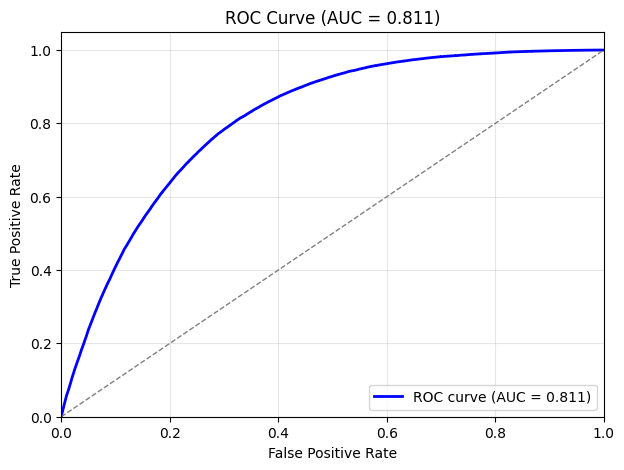

In [17]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Compute AUC
roc_auc = auc(fpr, tpr)
print("ROC-AUC:", roc_auc)

# Plot ROC curve with AUC
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

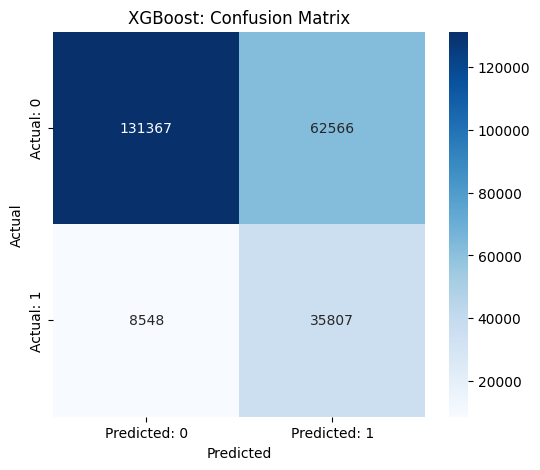

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: 0', 'Predicted: 1'],
            yticklabels=['Actual: 0', 'Actual: 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost: Confusion Matrix')
plt.show()

In [19]:
best_params.pop("eval_metric", None)
best_params["eval_metric"] = "error"

In [20]:
xgb_best = XGBClassifier(**best_params)

xgb_best.fit(
    X_train_final, y_train_final,
    eval_set=[(X_train_final, y_train_final), (X_val, y_val)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7845418742025242, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, feature_weights=None,
              gamma=3.896672504440196, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16480522932821431,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=841, n_jobs=-1,
              num_parallel_tree=None, ...)

In [21]:
# Evaluation results
results = xgb_best.evals_result()
train_error = results['validation_0']['error']
val_error   = results['validation_1']['error']
train_acc = [1 - e for e in train_error]
val_acc   = [1 - e for e in val_error]

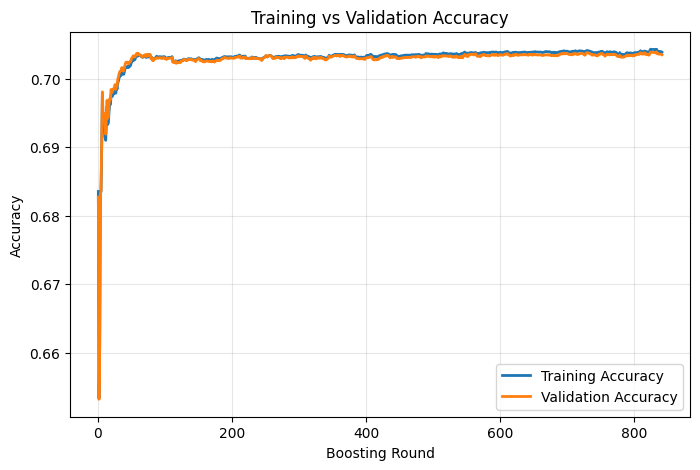

In [22]:
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2)
plt.xlabel("Boosting Round")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [23]:
best_params.pop("eval_metric", None)
best_params["eval_metric"] = "logloss"

In [24]:
xgb_best = XGBClassifier(**best_params)

xgb_best.fit(
    X_train_final, y_train_final,
    eval_set=[(X_train_final, y_train_final), (X_val, y_val)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7845418742025242, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=3.896672504440196, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16480522932821431,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=841, n_jobs=-1,
              num_parallel_tree=None, ...)

In [25]:
results = xgb_best.evals_result()

# Training and validation loss
train_loss = results['validation_0']['logloss']
val_loss   = results['validation_1']['logloss']

# Accuracy at each boosting round
train_error = results['validation_0']['error'] if "error" in results['validation_0'] else None
val_error   = results['validation_1']['error'] if "error" in results['validation_1'] else None

if train_error is None:
    best_params_acc = best_params.copy()
    best_params_acc["eval_metric"] = "error"

    temp_model = XGBClassifier(**best_params_acc)
    temp_model.fit(
        X_train_final, y_train_final,
        eval_set=[(X_train_final, y_train_final), (X_val, y_val)],
        verbose=False
    )
    res2 = temp_model.evals_result()
    train_error = res2['validation_0']['error']
    val_error   = res2['validation_1']['error']

train_acc = [1 - e for e in train_error]
val_acc   = [1 - e for e in val_error]

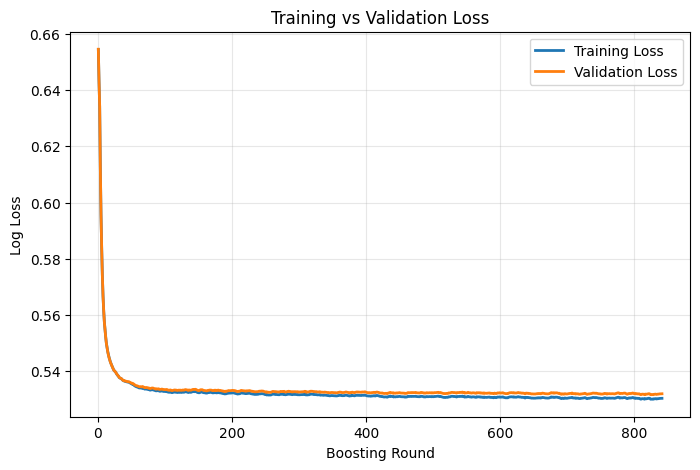

In [26]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss,   label='Validation Loss', linewidth=2)
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Model 2 — XGBoost for Multiclass Classification

In [27]:
from sklearn.linear_model import LogisticRegression

df = df.astype('category')

# Features and target
X = df.drop(columns=['breast_cancer_history'])
y = df['breast_cancer_history']

# Logistic regression
model = LogisticRegression(max_iter=5000)
model.fit(X, y)

# Predicted cancer probability
df['pred_prob'] = model.predict_proba(X)[:, 1]

# New 3-class column
df['breast_cancer_history_3class'] = df['breast_cancer_history'].copy()
df['breast_cancer_history_3class'] = df['breast_cancer_history_3class'].cat.add_categories([2])

# Thresholds for borderline high-risk class
lower_thresh = 0.35
upper_thresh = 0.50

# New class labeling
borderline_mask = (
    (df['breast_cancer_history'] == 0) &
    (df['pred_prob'] >= lower_thresh) &
    (df['pred_prob'] <= upper_thresh)
)

df.loc[borderline_mask, 'breast_cancer_history_3class'] = 2

print(df['breast_cancer_history_3class'].value_counts())
print(df['breast_cancer_history_3class'].dtype)

breast_cancer_history_3class
0.0    888887
1.0    221776
2.0     80775
Name: count, dtype: int64
category


In [28]:
df = df.drop(columns=['breast_cancer_history', 'pred_prob'])

In [29]:
df = df.astype('int')

In [30]:
# Features and multiclass target
X = df.drop(columns=['breast_cancer_history_3class'])
y = df['breast_cancer_history_3class'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Validation split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [31]:
# Class imbalance handling
class_counts = y_train_final.value_counts().sort_index()
scale_weights = class_counts.sum() / (len(class_counts) * class_counts)
scale_weights_dict = scale_weights.to_dict()
print("Class Weights:", scale_weights_dict)

Class Weights: {0: 0.44679054598423473, 1: 1.7907475382270537, 2: 4.916692458475188}


In [32]:
def objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 15),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "weights": y_train_final.map(scale_weights_dict),
        "n_jobs": -1
    }

    model = XGBClassifier(**params)
    model.fit(X_train_final, y_train_final)

    y_val_pred = model.predict(X_val)
    return recall_score(y_val, y_val_pred, average="macro")


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best Recall:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-12-09 05:44:10,680] A new study created in memory with name: no-name-3357ccf3-18fb-4c86-9485-188cbff66517
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:44:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-12-09 05:45:07,078] Trial 0 finished with value: 0.629692757165661 and parameters: {'n_estimators': 319, 'max_depth': 4, 'learning_rate': 0.1174709905717459, 'subsample': 0.8398273282483961, 'colsample_bytree': 0.8653654915823525, 'min_child_weight': 1, 'gamma': 4.289778477381246, 'reg_lambda': 3.5509065511706597, 'reg_alpha': 1.9992287375335693}. Best is trial 0 with value: 0.629692757165661.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:45:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "weights" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-12-09 05:46:43,131] Trial 1 finished with v

Best Recall: 0.6571963443701443
Best Params: {'n_estimators': 753, 'max_depth': 8, 'learning_rate': 0.2529011341955104, 'subsample': 0.9907208204147129, 'colsample_bytree': 0.9417503675680022, 'min_child_weight': 3, 'gamma': 0.6913442353269861, 'reg_lambda': 1.1235828658874956, 'reg_alpha': 3.5989964497583236}


In [33]:
best_params = study.best_params
best_params.update({
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "n_jobs": -1,
})

xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train_final, y_train_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9417503675680022, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.6913442353269861, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2529011341955104,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=753, n_jobs=-1, num_class=3, ...)

In [34]:
y_test_pred = xgb_best.predict(X_test)
y_test_proba = xgb_best.predict_proba(X_test)  # softmax probabilities

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Macro Recall:", recall_score(y_test, y_test_pred, average="macro"))
print("Macro Precision:", precision_score(y_test, y_test_pred, average="macro"))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Multiclass ROC-AUC
try:
    print("ROC-AUC (OvR):", roc_auc_score(y_test, y_test_proba, multi_class="ovr"))
except:
    print("ROC-AUC requires probability output")

Accuracy: 0.8118075605989391
Macro Recall: 0.6557360027554752
Macro Precision: 0.652978218224928

Confusion Matrix:
 [[170247   7344    187]
 [ 25239  10833   8283]
 [    81   3710  12364]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91    177778
           1       0.49      0.24      0.33     44355
           2       0.59      0.77      0.67     16155

    accuracy                           0.81    238288
   macro avg       0.65      0.66      0.64    238288
weighted avg       0.78      0.81      0.79    238288

ROC-AUC (OvR): 0.8944799148426664


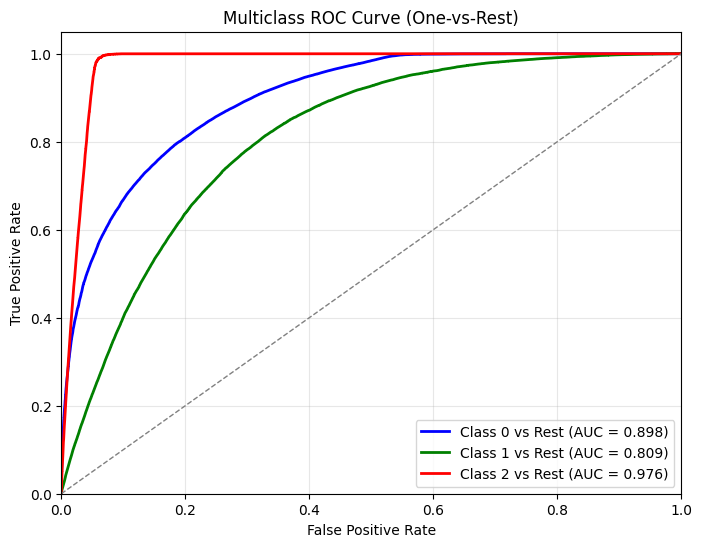

Class 0 AUC: 0.898
Class 1 AUC: 0.809
Class 2 AUC: 0.976


In [35]:
# Binarize the output for multiclass ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)  # shape = (n_samples, n_classes)
n_classes = y_test_bin.shape[1]

# Predict probabilities
y_test_proba = xgb_best.predict_proba(X_test)  # shape = (n_samples, n_classes)

# Plot ROC curves
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
roc_auc_dict = {}

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_dict[i] = roc_auc
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Class {classes[i]} vs Rest (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Print AUCs for each class
for cls, auc_val in roc_auc_dict.items():
    print(f'Class {cls} AUC: {auc_val:.3f}')

# Downsampling for the 3-Class Classification Task

Balanced Class Distribution:
breast_cancer_history_3class
0    221776
1    221776
2     80775
Name: count, dtype: int64


[I 2025-12-09 06:02:54,730] A new study created in memory with name: no-name-1c05908f-cd73-4890-834d-707d1803a4ec
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:02:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-12-09 06:03:36,446] Trial 0 finished with value: 0.3079739858486068 and parameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.23688990072107854, 'subsample': 0.8740962257261138, 'colsample_bytree': 0.8112346922216152}. Best is trial 0 with value: 0.3079739858486068.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:03:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-12-09 06:04:17,436] Trial 1 finished with value: 0.33939503747639843 and parameters: {'n_estimators': 334, 'max_depth': 5, 'learning_rate'

Best Hyperparameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.23688990072107854, 'subsample': 0.8740962257261138, 'colsample_bytree': 0.8112346922216152}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:10:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Accuracy: 0.7114416948775409
Validation Accuracy: 0.6920260141513932
Test Accuracy: 0.693542234852097

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.78      0.75      0.77     44356
           1       0.65      0.61      0.63     44355
           2       0.60      0.76      0.67     16155

    accuracy                           0.69    104866
   macro avg       0.68      0.71      0.69    104866
weighted avg       0.70      0.69      0.69    104866



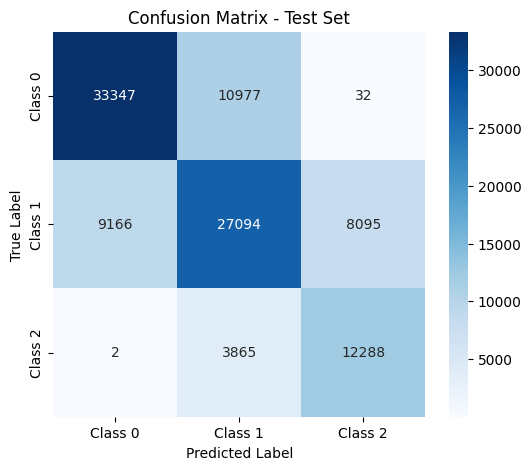

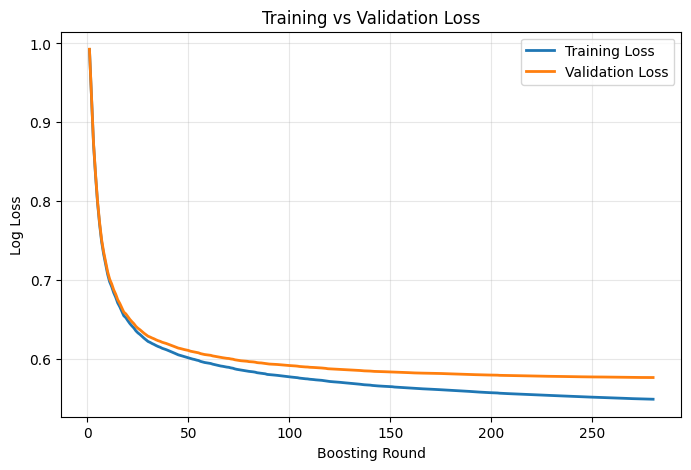

In [36]:
# Balanced Downsampling
def downsample_df(df, target_col="breast_cancer_history_3class"):
    df_0 = df[df[target_col] == 0]
    df_1 = df[df[target_col] == 1]
    df_2 = df[df[target_col] == 2]

    df_0_down = resample(df_0, replace=False, n_samples=len(df_1), random_state=42)
    df_balanced = pd.concat([df_0_down, df_1, df_2], ignore_index=True)
    return df_balanced

df_balanced = downsample_df(df)
print("Balanced Class Distribution:")
print(df_balanced["breast_cancer_history_3class"].value_counts())

# Feature and Target Split
X = df_balanced.drop(columns=["breast_cancer_history_3class"])
y = df_balanced["breast_cancer_history_3class"].values.ravel()

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Optuna Hyperparameter Tuning
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'n_jobs': -1,
        'seed': 42
    }
    model = XGBClassifier(**params)
    model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)
    preds = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, preds)
    return 1 - acc

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)

# Final model with best params
best_params = study.best_params
xgb_final = XGBClassifier(
    **best_params,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1,
    seed=42
)

xgb_final.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# Evaluation
y_train_pred = xgb_final.predict(X_train_scaled)
y_val_pred   = xgb_final.predict(X_val_scaled)
y_test_pred  = xgb_final.predict(X_test_scaled)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Training vs Validation Loss Plot
results = xgb_final.evals_result()
train_loss = results['validation_0']['mlogloss']
val_loss   = results['validation_1']['mlogloss']

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', linewidth=2)
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

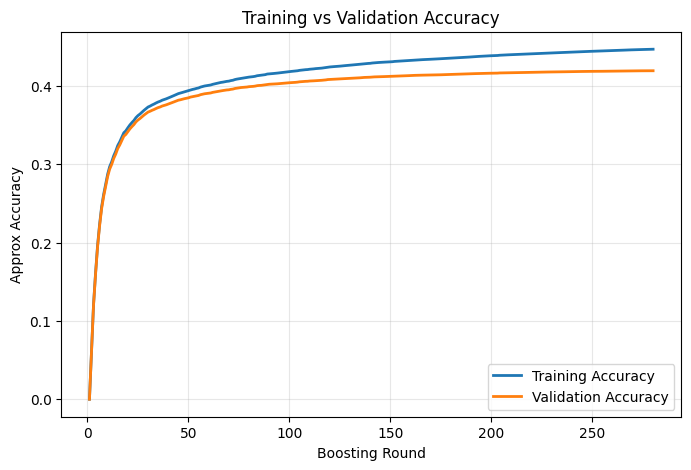

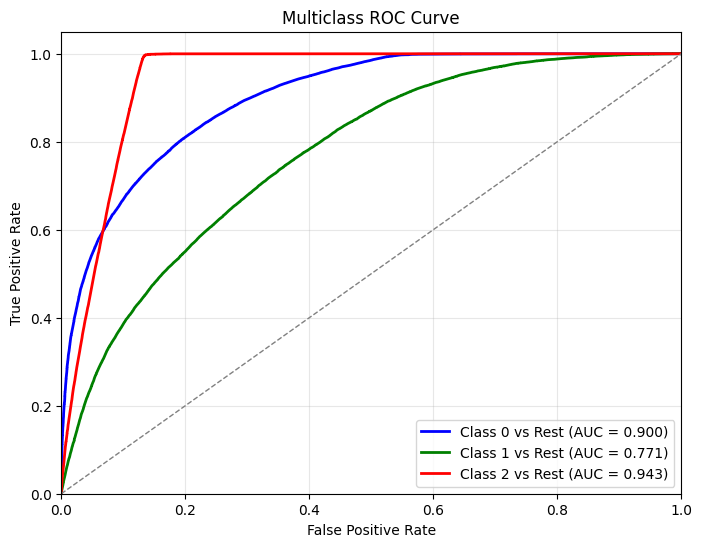

Class 0 AUC: 0.900
Class 1 AUC: 0.771
Class 2 AUC: 0.943


In [37]:
# Compute training and validation accuracy over boosting rounds
results = xgb_final.evals_result()
train_loss = np.array(results['validation_0']['mlogloss'])
val_loss   = np.array(results['validation_1']['mlogloss'])

train_acc = 1 - train_loss / max(train_loss)
val_acc   = 1 - val_loss / max(val_loss)

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs, val_acc, label='Validation Accuracy', linewidth=2)
plt.xlabel("Boosting Round")
plt.ylabel("Approx Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ROC-AUC for multiclass (one-vs-rest)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Predicted probabilities
y_proba_test = xgb_final.predict_proba(X_test_scaled)

plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
roc_auc_dict = {}

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_dict[i] = roc_auc
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Class {classes[i]} vs Rest (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

for cls, auc_val in roc_auc_dict.items():
    print(f'Class {cls} AUC: {auc_val:.3f}')

# Adding Explainability Using SHAP

In [38]:
!pip install shap

SHAP values shape: (200, 14, 3)


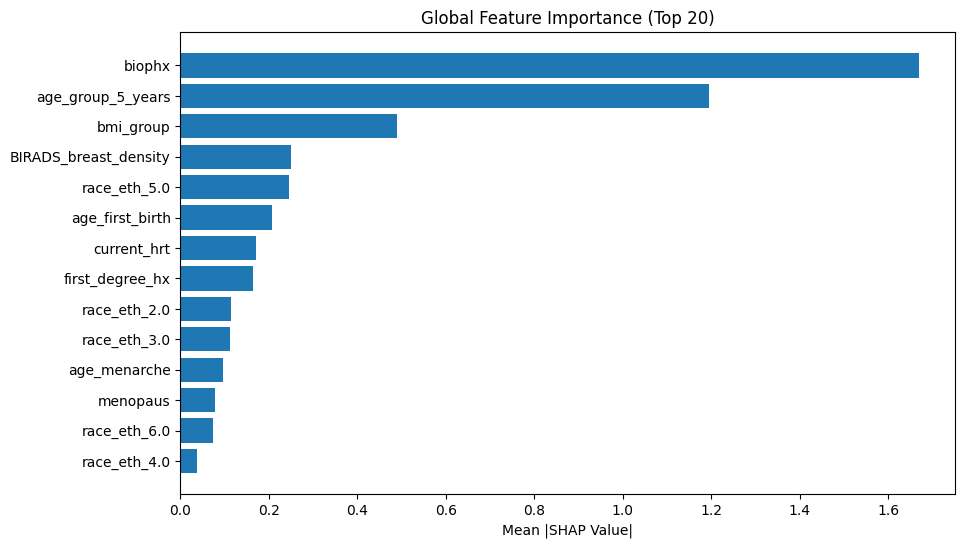

SHAP Summary Plot for Class 0


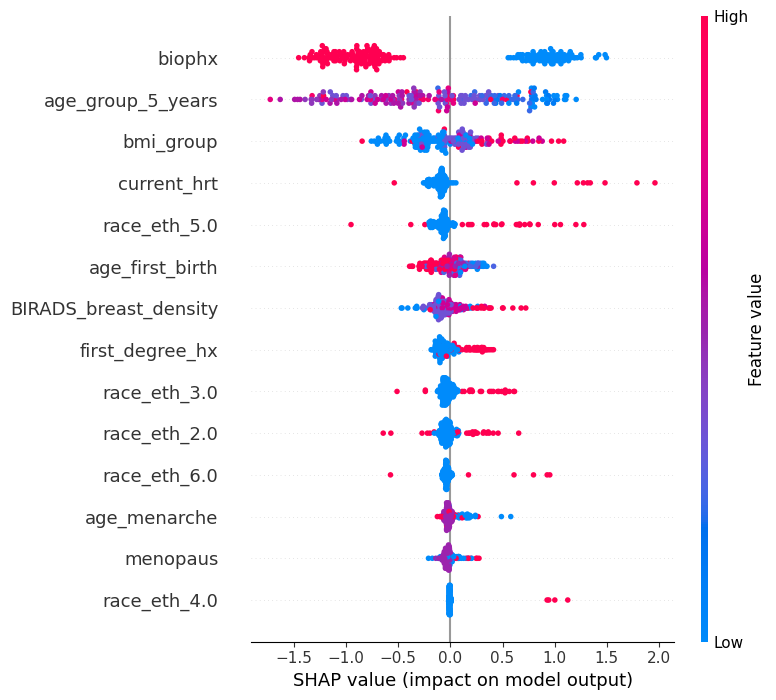

SHAP Summary Plot for Class 1


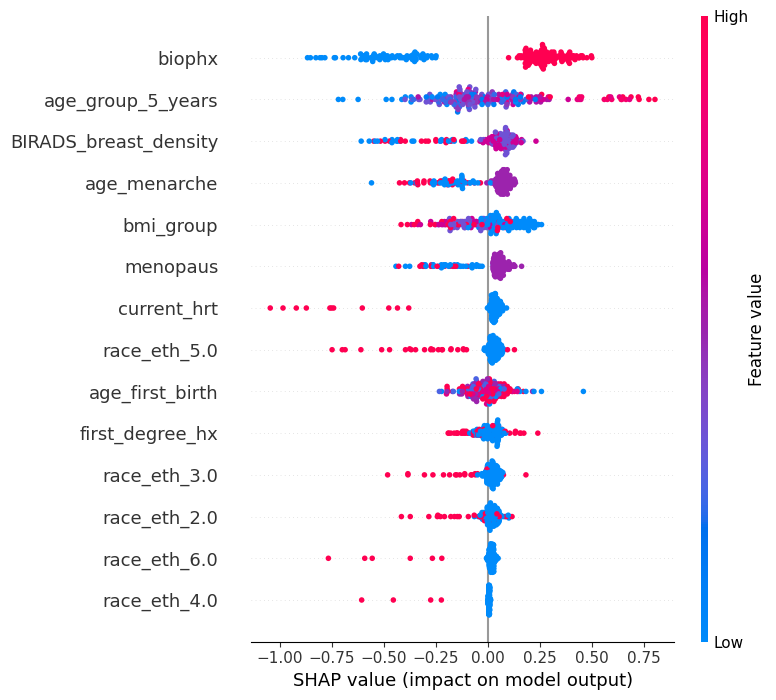

SHAP Summary Plot for Class 2


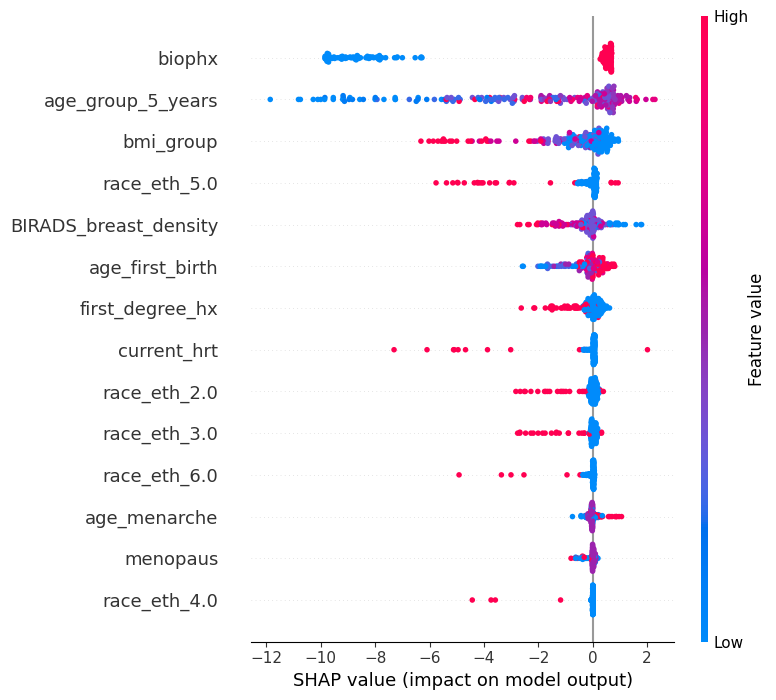

In [39]:
import shap

# Take a random subset of test data for SHAP
subset_size = 200
idx = np.random.choice(X_test_scaled.shape[0], subset_size, replace=False)
X_shap = X_test_scaled[idx, :]

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_final, model_output="raw")

# Compute SHAP values
shap_values = explainer.shap_values(X_shap)
print(f"SHAP values shape: {shap_values.shape}")

# Global feature importance
mean_abs_shap = np.mean(np.abs(shap_values), axis=(0, 2))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': mean_abs_shap
}).sort_values(by='importance', ascending=False)

# Keep top 20 features for plotting
top_features = feature_importance['feature'].iloc[:20].tolist()

plt.figure(figsize=(10,6))
plt.barh(feature_importance['feature'].iloc[:20], feature_importance['importance'].iloc[:20])
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP Value|")
plt.title("Global Feature Importance (Top 20)")
plt.show()

# Summary plots per class
feature_indices = [X.columns.get_loc(f) for f in top_features]
n_classes = shap_values.shape[2]

for i in range(n_classes):
    print(f"SHAP Summary Plot for Class {i}")
    shap.summary_plot(
        shap_values[:, feature_indices, i],
        X_shap[:, feature_indices],
        feature_names=top_features
    )

# Plot for a single sample
sample_idx = 0
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values[sample_idx, :, 0],
    X_shap[sample_idx],
    feature_names=X.columns
)